>"**We want to know what the brain sees**, how it thinks, and how it decides. We want to map out the murine mind in a quantitative manner." -  Allen Institute for Brain Science Mission Statement

To know what the mouse brain sees, we take the behavioral detection thresholds of UV luminance contrast, green luminance contrast, and UV-green oppoenency to develop an image manipulation tools: **MouseView**. 

**MouseView** convolves detection thresholds with RBG images to simuluate the mouse visual experience. **MouseView** uses the mouse eye position (estimated or measured) to align the visuotopic measurements of threshold with the presented image. **MouseView** can use the color profile of typical displays (e.g., LCD monitors), or take exact measurement of the spectral properties of your display. Color is represented using blue-green encoding (or [viridis,GnBu,PuBuGn]). Images can be adjusted for mouse spatial resolution, using published behavioral measures or estimates from physiological measures.    

**MouseView** can also adjust the RGB weights of images to make them perceptually uniform. 

 

imports

In [1]:
from djd.behavior_analysis import *

UV='#4B0082'
Green='#6B8E23'
Blue = '#0033cc'

%matplotlib inline
%load_ext autoreload
%autoreload 2 
sns.set_style("white")
import warnings
warnings.filterwarnings('ignore')

#sns.set_palette(['#4d0000','#cc0000','#ff6666','#ffb3b3'])
sns.set_palette(['#d9d9d9','#a6a6a6','#666666','#000000']) # gray scale
sns.set_palette(["#11a421",
"#00b9d6",
"#027cfc",
"#e158d8",
"#e891ac"])# from http://tools.medialab.sciences-po.fr/iwanthue/; HCL; H [109 - 360]; hard

/Users/administrator/anaconda/lib/python2.7/site-packages/imaging_behavior/core/tifffile.py:2170: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
/Users/administrator/anaconda/lib/python2.7/site-packages/imaging_behavior/core/tifffile.py:2170: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
/Users/administrator/anaconda/lib/python2.7/site-packages/imaging_behavior/core/tifffile.py:2170: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


In [2]:
filename =  '/Volumes/Public/Dan/dome/uvProjector2_Warp2_colorAdjustment.data'
warp2 = [];
[warp2.append(row) for row in csv.reader(open(filename))];
rows2 = int(warp2[1][0].split(' ')[1])
cols2 = int(warp2[1][0].split(' ')[0])

intensity_new_r2 = np.zeros((rows2,cols2))
intensity_new_g2 = np.zeros((rows2,cols2))
intensity_new_u2 = np.zeros((rows2,cols2))
intensity_new_alpha = np.zeros((rows2,cols2))

line=0
for i in range(rows2)[::-1]:
    for j in range(cols2):
        intensity_new_r2[i][j] = warp2[line+2][0].split('\t')[-4]
        intensity_new_g2[i][j] = warp2[line+2][0].split('\t')[-3]
        intensity_new_u2[i][j] = warp2[line+2][0].split('\t')[-2]
        intensity_new_alpha[i][j] = warp2[line+2][0].split('\t')[-1]
        line+=1
        
# fig,ax = plt.subplots(1,3)
# ax[0].imshow(intensity_new_r2,clim=(0,1));ax[0].set_title('R')
# ax[1].imshow(intensity_new_g2,clim=(0,1));ax[1].set_title('G')
# ax[2].imshow(intensity_new_u2,clim=(0,1));ax[2].set_title('U')
# plt.tight_layout()

**load mouse data to apply to images**
1. cone fundamentals from Joesch and Meister, 2016
2. cone fundamentals from Lyubarksy et al., 1999
3. LED spectra for the Allen UV dome 
4. basis functions for sRGB color space

1 cone fundamentals from Joesch and Meister, 2016

In [3]:
gr = np.sort(np.loadtxt('/Users/administrator/Desktop/joesch_s2_green.data').view('i8,i8,i8'), order=['f2'], axis=0).view(np.float)
uv = np.sort(np.loadtxt('/Users/administrator/Desktop/joesch_s2_UV.data').view('i8,i8,i8'), order=['f2'], axis=0).view(np.float)
# plt.plot(uv[:,0],uv[:,1],color='k')
# plt.plot(gr[:,0],gr[:,1],color='g')
# plt.title('Joesch and Meister S2')

gr2 = interp1d(gr[:,0],gr[:,1])(np.arange(352,600))
uv2 = interp1d(uv[:,0],uv[:,1])(np.arange(352,600))
# plt.figure()
# plt.plot(uv2,color='k')
# plt.plot(gr2,color='g')
# plt.title('Joesch and Meister S2')

2 description of cone fundamentals, from Lyubarsky et al 1999

In [4]:
wavelengths = np.arange(350,600)
green_cone = np.array([ 0.2663895 ,  0.26595151, 0.2663895 ,  0.26595151,  0.26551351,  0.26507551,  0.26463751,0.26419951,  0.26376152,  0.26332352,  0.26093815,  0.25812743,0.25531671,  0.25250599,  0.24969527,  0.24688455,  0.24474235,0.24389064,  0.24303892,  0.24218721,  0.24133549,  0.24048378,0.23963206,  0.23878035,  0.23792864,  0.23707692,  0.23514114,0.23254663,  0.22995212,  0.22735761,  0.2247631 ,  0.22216859,0.21957408,  0.21766776,  0.21621531,  0.21476285,  0.2133104 ,0.21185794,  0.21040548,  0.20895303,  0.20750057,  0.20604812,0.20459566,  0.20349159,  0.20305359,  0.20261559,  0.20217759,0.20173959,  0.2013016 ,  0.2008636 ,  0.2004256 ,  0.20073163,0.20124263,  0.20175363,  0.20226462,  0.20277562,  0.20328662,0.20414483,  0.20579596,  0.20744709,  0.20909822,  0.21074934,0.21240047,  0.2140516 ,  0.21630044,  0.22004806,  0.22379569,0.22754331,  0.23129094,  0.23532846,  0.23975741,  0.24418637,0.24861532,  0.25304428,  0.25822026,  0.26396933,  0.2697184 ,0.27546747,  0.28115997,  0.2866793 ,  0.29219863,  0.29771796,0.30323729,  0.30875662,  0.31664937,  0.32497199,  0.33329462,0.34177854,  0.35251026,  0.36324199,  0.37397371,  0.38386002,0.39356975,  0.40327948,  0.4129892 ,  0.42269893,  0.43240866,0.44300682,  0.45527151,  0.46753619,  0.4781454 ,  0.48785512,0.49756485,  0.50856792,  0.52144598,  0.53432405,  0.54521628,0.55529116,  0.56536604,  0.57544092,  0.58982784,  0.60454569,0.61856156,  0.63021323,  0.6418649 ,  0.65351658,  0.66516825,0.67681992,  0.68770861,  0.69844033,  0.70917206,  0.72116933,0.7340474 ,  0.74692547,  0.75789389,  0.76862592,  0.77935795,0.79008978,  0.8008215 ,  0.81155322,  0.82165581,  0.83085443,0.84005305,  0.84925167,  0.85872661,  0.86836336,  0.87800011,0.88763685,  0.89559606,  0.90326149,  0.91092692,  0.91859234,0.92544329,  0.93157577,  0.93770825,  0.94384072,  0.9499732 ,0.95610568,  0.96157836,  0.96659594,  0.97161351,  0.97663108,0.98164866,  0.98666623,  0.99004729,  0.99255591,  0.99506453,0.99757315,  1.00008176,  1.00259038,  1.00112561,  0.99805944,0.99499327,  0.99192709,  0.98886092,  0.98541062,  0.98111787,0.97682512,  0.97253237,  0.96823961,  0.96394686,  0.95587232,0.94744017,  0.93900801,  0.93057586,  0.92298929,  0.91598079,0.90897229,  0.90196379,  0.88942702,  0.87562916,  0.86132953,0.84676494,  0.83485438,  0.82565581,  0.81645723,  0.80491415,0.78651639,  0.76746986,  0.74817402,  0.73693146,  0.72568889,0.71444633,  0.69943893,  0.68334088,  0.67054608,  0.65981436,0.64908263,  0.63354967,  0.61004223,  0.590977  ,  0.57334596,0.5563548 ,  0.53979718,  0.52323956,  0.50961361,  0.49632675,0.48303988,  0.46639751,  0.44800011,  0.42960271,  0.4135525 ,0.39760827,  0.38182158,  0.36649036,  0.35115913,  0.33924521,0.33004659,  0.32084796,  0.31164934,  0.30040716,  0.28858029,0.27675342,  0.26492655,  0.25062274,  0.23631357,  0.2220044 ,0.21098843,  0.20102328,  0.19105813,  0.18109298,  0.17179996,0.16336781,  0.15493565,  0.1465035 ,  0.13826357,  0.13144965,0.12463573,  0.11782181,  0.11100789,  0.10452955,  0.09901041,0.09349126,  0.08797212,  0.08245297,  0.07693383,  0.07121703,0.06546796,  0.05971889,  0.05396982])
uv_cone = np.array([8.55815491e-01,   8.66480435e-01, 8.77815491e-01,   8.89480435e-01,   9.01112864e-01,9.12624519e-01,   9.23968072e-01,   9.31949583e-01,9.39931094e-01,   9.47492579e-01,   9.54245912e-01,9.60999245e-01,   9.67362065e-01,   9.73501733e-01,9.79641158e-01,   9.85780583e-01,   9.91133783e-01,9.94715207e-01,   9.98296632e-01,   1.00156798e+00,1.00003322e+00,   9.98498456e-01,   9.96963692e-01,9.92680668e-01,   9.87769054e-01,   9.82641501e-01,9.75734600e-01,   9.68827700e-01,   9.56850990e-01,9.50918464e-01,   9.46006480e-01,   9.38989651e-01,9.20571489e-01,   9.02152472e-01,   8.92102947e-01,8.82126518e-01,   8.46365647e-01,   8.22249893e-01,8.05877838e-01,   7.89505790e-01,   7.73133746e-01,7.53335902e-01,   7.25654579e-01,   7.14910306e-01,6.94059728e-01,   6.62657783e-01,   6.28890295e-01,6.00239525e-01,   5.64040311e-01,   5.42671217e-01,5.14950200e-01,   4.81541712e-01,   4.61587931e-01,4.29089342e-01,   3.92690615e-01,   3.67109357e-01,3.45441795e-01,   3.24721093e-01,   2.94658034e-01,2.67641282e-01,   2.47175918e-01,   2.30059558e-01,2.13175766e-01,   1.83281950e-01,   1.64908939e-01,1.53507043e-01,   1.42105148e-01,   1.30703253e-01,1.15747645e-01,   1.00399080e-01,   8.89231178e-02,7.88367343e-02,   6.87503509e-02,   5.86639674e-02,5.31923514e-02,   4.79735990e-02,   4.27548466e-02,3.75360942e-02,   3.23173418e-02,   2.85430013e-02,2.60150462e-02,   2.34870912e-02,   2.09591361e-02,1.84311810e-02,   1.59032259e-02,   1.33752709e-02,1.08473158e-02,   8.31936071e-03,   6.60923838e-03,6.50332886e-03,   6.39741934e-03,   6.29150981e-03,6.18560029e-03,   6.07969077e-03,   5.97378125e-03,5.86787173e-03,   5.76196220e-03,   5.65605268e-03,5.55014316e-03,   5.44423364e-03,   5.33832412e-03,5.23241459e-03,   5.12650507e-03,   5.02059555e-03,4.90380348e-03,   4.78102236e-03,   4.65824125e-03,4.53546013e-03,   4.41267902e-03,   4.28989790e-03,4.16711678e-03,   4.04433567e-03,   3.92155455e-03,3.79877344e-03,   3.67599232e-03,   3.55321121e-03,3.43043009e-03,   3.32200000e-03,   3.32200000e-03,3.32200000e-03,   3.32200000e-03,   3.32200000e-03,3.32200000e-03,   3.32200000e-03,   3.32200000e-03,3.32200000e-03,   3.32200000e-03,   3.24492968e-03,3.04029447e-03,   2.83565927e-03,   2.63102407e-03,2.42638886e-03,   2.22175366e-03,   2.01711846e-03,1.81248326e-03,   1.49015444e-03,   8.32398394e-04,1.74642344e-04,  -4.83113706e-04,  -1.14086976e-03,-1.79862581e-03,  -2.45638186e-03,  -3.11413791e-03,-2.92834283e-03,  -2.35280636e-03,  -1.77726988e-03,-1.20173340e-03,  -6.26196925e-04,  -5.06604473e-05,5.24876030e-04,   1.10041251e-03,   1.66100000e-03,1.66100000e-03,   1.66100000e-03,   1.66100000e-03,1.66100000e-03,   1.66100000e-03,   1.66100000e-03,1.66100000e-03,   1.66100000e-03,   1.52811998e-03,1.38195198e-03,   1.23578397e-03,   1.08961597e-03,9.43447964e-04,   7.97279959e-04,   6.51111954e-04,5.04943950e-04,   3.58775945e-04,   2.12607940e-04,6.64399357e-05,  -1.28791483e-04,  -3.64909006e-04,-6.01026529e-04,  -8.37144052e-04,  -1.07326157e-03,-1.30937910e-03,  -1.54549662e-03,  -1.78161414e-03,-2.01773167e-03,  -2.25384919e-03,  -2.48996671e-03,-2.72608423e-03,  -2.96220176e-03,  -3.19831928e-03,-3.25844876e-03,  -3.12499101e-03,  -2.99153327e-03,-2.85807553e-03,  -2.72461778e-03,  -2.59116004e-03,-2.45770229e-03,  -2.32424455e-03,  -2.19078681e-03,-2.05732906e-03,  -1.92387132e-03,  -1.79041357e-03,-1.66504417e-03,  -1.79850191e-03,  -1.93195966e-03,-2.06541740e-03,  -2.19887515e-03,  -2.33233289e-03,-2.46579063e-03,  -2.59924838e-03,  -2.73270612e-03,-2.86616387e-03,  -2.99962161e-03,  -3.13307935e-03,-3.26653710e-03,  -3.32200000e-03,  -3.32200000e-03,-3.32200000e-03,  -3.32200000e-03,  -3.32200000e-03,-3.32200000e-03,  -3.32200000e-03,  -3.32200000e-03,-3.32200000e-03,  -3.32200000e-03,  -3.32200000e-03,-3.32200000e-03,  -3.32200000e-03,  -3.32200000e-03,-3.32200000e-03,  -3.32200000e-03,  -3.32200000e-03,-3.32200000e-03,  -3.32200000e-03,  -3.32200000e-03,-3.32200000e-03,  -3.32200000e-03,  -3.32200000e-03,-3.32200000e-03,  -3.32200000e-03,  -3.32200000e-03,-3.32200000e-03,  -3.32200000e-03,  -3.32200000e-03,-3.32200000e-03,  -3.32200000e-03,  -3.32200000e-03,-3.32200000e-03,  -3.32200000e-03,  -3.32200000e-03,-3.32200000e-03,  -3.32200000e-03,  -3.32200000e-03,-3.32200000e-03,  -3.32200000e-03])

3 LED spectra for the Allen UV dome 

In [5]:
LEDgreen= np.zeros(250)
LEDgreen[30:] = jeti.jetitodict('/Volumes/DATA2/behavior/green_set2.csv')['green_100'][:220]
LEDuv= np.zeros(250)
LEDuv[30:]   = jeti.jetitodict('/Volumes/DATA2/behavior/uv_set1.csv')['uv_100'][:220]
max =np.concatenate((LEDgreen,LEDuv)).max()
LEDgreen /= max
LEDuv /=max# np.concatenate((LEDgreen,LEDuv)).max()

4 basis functions for sRGB color space

In [6]:
cie2006=[]
[cie2006.append(row) for row in csv.reader(open('/Users/administrator/Downloads/lin2012xyz2e_1_7sf.csv'))];
sRGB_X = np.zeros(250);sRGB_X[50:]=np.array(cie2006)[:,1].astype(float)[:200]#convert to wavelength range 350-600
sRGB_Y = np.zeros(250);sRGB_Y[50:]=np.array(cie2006)[:,2].astype(float)[:200]#convert to wavelength range 350-600
sRGB_Z = np.zeros(250);sRGB_Z[50:]=np.array(cie2006)[:,3].astype(float)[:200]#convert to wavelength range 350-600

**MouseView**
1. use RGB image and a specificed display colorspace (sRBG, mouse, custom) to compute displayed spectral radiance
2. convolve with cone fundamentals (from Lubyarsky et al., 1999 or Joesch and Meister, 2016)
3. multiply by cone weight at that point in space, from figure SX
4. subtract computed mouse UV image from mouse Green image to get oppoenent image
5. add computed mouse UV image from mouse Green image to get luminance image
6. apply colormaps to each image (grayscale) and modified Gn-Pu
7. add images to get MouseView
![image of MouseView schematic](https://www.dropbox.com/s/rerp5zx0heq0jzk/IMG_20170525_133530.jpg)

## load an image

(275, 450, 3)


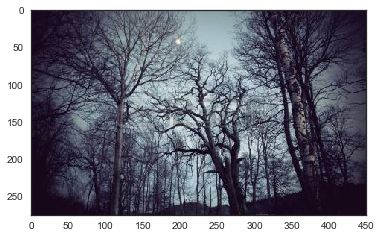

In [16]:
image = ndimage.imread('/Volumes/DATA2/behavior/figures/example_images/dark_forest.jpg') #from http://colorvisiontesting.com/what%20colorblind%20people%20see.htm
#image = ndimage.imread('/Volumes/Public/Dan/CAM_stimuli/NaturalImages/BSDS_41004.tiff').T # from BOb
if np.shape(image.shape)[0] == 2:
    image = np.stack((image,image,image)).T
print image.shape
plt.imshow(image,cmap=mouse_cmap)

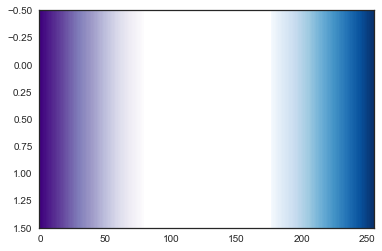

In [8]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
plt.imshow(gradient, aspect='auto', cmap=mouse_cmap)
plt.gcf().savefig('/Volumes/DATA2/behavior/figures/MouseView/mouse_cmap.png',format='png')

### typical sRGB display

In [9]:
plt.imshow(dsfs[:,:,2])

NameError: name 'dsfs' is not defined

In [10]:
a = np.reshape(dsfs,(307,320,3))

NameError: name 'dsfs' is not defined

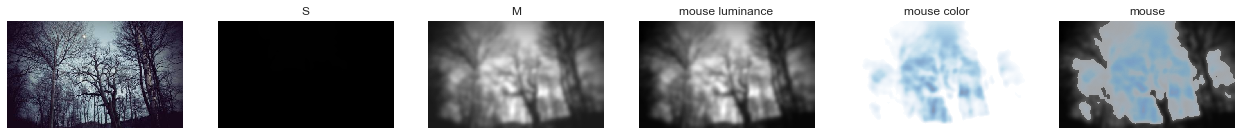

In [17]:
X = sRGB_X#np.zeros(250);X[50:]=np.array(cie2006)[:,1].astype(float)[:200]#convert to wavelength range 350-600
Y = sRGB_Y#np.zeros(250);Y[50:]=np.array(cie2006)[:,2].astype(float)[:200]#convert to wavelength range 350-600
Z = sRGB_Z#np.zeros(250);Z[50:]=np.array(cie2006)[:,3].astype(float)[:200]#convert to wavelength range 350-600

spatial_smooth=5. # 5º, based on fig 5. from Histed 2012 and from the sigma of LGN receptive fields from Denman et al,. 2016

x_ = np.einsum('i,jk->jki', X, ndimage.gaussian_filter(image[:,:,0],spatial_smooth))
y_ = np.einsum('i,jk->jki', Y, ndimage.gaussian_filter(image[:,:,1],spatial_smooth))
z_ = np.einsum('i,jk->jki', Z, ndimage.gaussian_filter(image[:,:,2],spatial_smooth))

cone_images_x = np.dot(x_,np.vstack((uv_cone,green_cone)).T)
cone_images_y = np.dot(y_,np.vstack((uv_cone,green_cone)).T)
cone_images_z = np.dot(z_,np.vstack((uv_cone,green_cone)).T)
cone_images = cone_images_x+cone_images_y+cone_images_z

uv_w = np.zeros((z_.shape[0],z_.shape[1]))
g_w = np.ones((z_.shape[0],z_.shape[1]))
uv_elevation_weight = intensity_new_g2[:,53][np.linspace(intensity_new_g2.shape[0]-1-20,0,z_.shape[0]).astype(int)]
for i in range(uv_elevation_weight.shape[0]):
    uv_w[i,:] = uv_elevation_weight[::-1][i] / (1+uv_elevation_weight[::-1][i]) 
g_w -= uv_w
cone_images[:,:,0] = cone_images[:,:,0] * uv_w
cone_images[:,:,1] = cone_images[:,:,1] * g_w

f,ax=plt.subplots(1,6,figsize=(22,6))
ax[0].imshow(image)
ax[1].imshow(cone_images[:,:,0],cmap=plt.cm.gray,clim=(0,np.max(cone_images)));ax[1].set_title('S')
c=ax[2].imshow(cone_images[:,:,1],cmap=plt.cm.gray,clim=(0,np.max(cone_images)));ax[2].set_title('M')
ax[3].imshow(np.sum(cone_images,axis=2),cmap=plt.cm.gray);ax[3].set_title('mouse luminance')
ax[4].imshow(cone_images[:,:,1]-cone_images[:,:,0],cmap=mouse_cmap,clim=(-1*np.max(cone_images),np.max(cone_images)),alpha=0.5);ax[4].set_title('mouse color')
# dsfs = np.stack((np.zeros(np.shape(cone_images[:,:,0])),cone_images[:,:,1],cone_images[:,:,0])).T
# dsfs/=np.max(dsfs)
# dsfs*=255.
# ax[5].imshow(dsfs)
ax[5].imshow(np.sum(cone_images,axis=2),cmap=plt.cm.gray);
ax[5].imshow(cone_images[:,:,1]-cone_images[:,:,0],cmap=mouse_cmap,clim=(-1*np.max(cone_images),np.max(cone_images)),alpha=.5);ax[5].set_title('mouse')
for a in ax:
    cleanAxes(a,total=True)
plt.gcf().savefig('/Volumes/DATA2/behavior/figures/MouseView/sRGB.eps',format='eps')

### UV dome

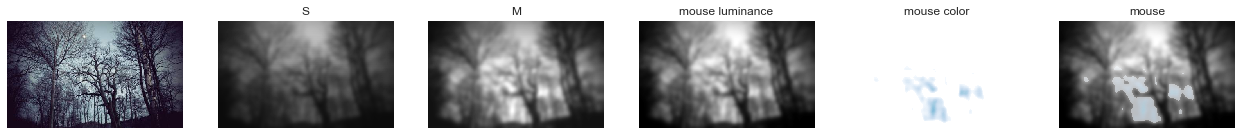

In [18]:
X=np.zeros(250) #R
Y=LEDgreen   #G
Z=LEDuv   #B
spatial_smooth=5. # 5º, based on fig 5. fr fr

x_ = np.einsum('i,jk->jki', X, ndimage.gaussian_filter(image[:,:,0],spatial_smooth))
y_ = np.einsum('i,jk->jki', Y, ndimage.gaussian_filter(image[:,:,1],spatial_smooth))
z_ = np.einsum('i,jk->jki', Z, ndimage.gaussian_filter(image[:,:,2],spatial_smooth))

cone_images_x = np.dot(x_,np.vstack((uv_cone,green_cone)).T)
cone_images_y = np.dot(y_,np.vstack((uv_cone,green_cone)).T)
cone_images_z = np.dot(z_,np.vstack((uv_cone,green_cone)).T)
cone_images = cone_images_x+cone_images_y+cone_images_z

uv_w = np.zeros((z_.shape[0],z_.shape[1]))
g_w = np.ones((z_.shape[0],z_.shape[1]))
uv_elevation_weight = intensity_new_g2[:,53][np.linspace(intensity_new_g2.shape[0]-1-20,0,z_.shape[0]).astype(int)]
for i in range(uv_elevation_weight.shape[0]):
    uv_w[i,:] = uv_elevation_weight[::-1][i] / (1+uv_elevation_weight[::-1][i]) 
g_w -= uv_w
cone_images[:,:,0] = cone_images[:,:,0] * uv_w
cone_images[:,:,1] = cone_images[:,:,1] * g_w

f,ax=plt.subplots(1,6,figsize=(22,6))
ax[0].imshow(image)
ax[1].imshow(cone_images[:,:,0],cmap=plt.cm.gray,clim=(0,np.max(cone_images)));ax[1].set_title('S')
c=ax[2].imshow(cone_images[:,:,1],cmap=plt.cm.gray,clim=(0,np.max(cone_images)));ax[2].set_title('M')
ax[3].imshow(np.sum(cone_images,axis=2),cmap=plt.cm.gray);ax[3].set_title('mouse luminance')
ax[4].imshow(cone_images[:,:,1]-cone_images[:,:,0],cmap=mouse_cmap,clim=(-1*np.max(cone_images),np.max(cone_images)));ax[4].set_title('mouse color')
ax[5].imshow(np.sum(cone_images,axis=2),cmap=plt.cm.gray);ax[3].set_title('mouse luminance')
ax[5].imshow(cone_images[:,:,1]-cone_images[:,:,0],cmap=mouse_cmap,clim=(-1*np.max(cone_images),np.max(cone_images)),alpha=.5);ax[5].set_title('mouse')
for a in ax:
    cleanAxes(a,total=True)
plt.gcf().savefig('/Volumes/DATA2/behavior/figures/MouseView/dome.eps',format='eps')